In [2]:
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.keras import Model
import tensorflow as tf
import tensorflow_addons as tfa

from IPython import display

### U-Net diffusion model

In [44]:
class U_Net(Model):

    def __init__(self, image_shape, num_channels, emb_dim=512, gate_filters=32, num_resolutions=4, attn_res_idx=2):
        super().__init__()
        
        self.image_shape = image_shape
        self.num_channels = num_channels
        self.num_resolutions = num_resolutions
        self.attn_res_idx = attn_res_idx
        self.emb_dim = emb_dim
        self.gate_filters = gate_filters
        self.model = self.build_graph()
        
    def timestep_embedding(self, ts, embedding_dim):
        assert len(ts.shape)==1
        
        half_dim = embedding_dim // 2
        emb = -(tf.math.log(10000.0)/(half_dim-1))
        
        idxs = tf.range(half_dim, dtype=tf.float32)
        emb = tf.math.exp(idxs*emb)
        
        ts = tf.cast(ts, dtype=tf.float32)
        
        emb = ts[:,None]* emb[None,:]
        
        pe = tf.concat([tf.sin(emb), tf.cos(emb)], axis=1)
        
        return pe
    
    def nonlinearity(self, x):
        return tf.keras.activations.swish(x)
    
    def normalize(self, x):
        return tfa.layers.InstanceNormalization(axis=-1)(x)
        
    def ResBlK(self, x, temb):
        h = self.nonlinearity(self.normalize(x))
        h = layers.Conv2D(x.shape[-1], (1, 1),
                                        strides=(1, 1), padding='same')(h)
        
        temb = self.nonlinearity(temb)
        h +=  layers.Dense(h.shape[-1])(temb)
        
        h = self.nonlinearity(self.normalize(h))
        h = layers.Conv2D(x.shape[-1], (1, 1),
                                        strides=(1, 1), padding='same')(h)
        
        return x+h
        
    def downsample(self, x, filters, factor=2):
        return layers.Conv2D(filters, (3, 3),
                                        strides=(factor, factor), padding='same')(x)

    def upsample(self, x, filters, factor=2):
        return layers.Conv2DTranspose(filters, (3, 3),
                                       strides=(factor, factor), padding='same')(x)
        
    def NonlocalGaussian(self, x):
        h = self.normalize(x)
        theta = layers.Conv2D(x.shape[-1]/2.0, (1, 1),
                                        strides=(1, 1), padding='same')(h)
        phi = layers.Conv2D(x.shape[-1]/2.0, (1, 1),
                                        strides=(1, 1), padding='same')(h)
        g = layers.Conv2D(x.shape[-1]/2.0, (1, 1),
                                        strides=(1, 1), padding='same')(h)
        phi = tf.transpose(phi, (0, 3, 2, 1))

        theta = tf.reshape(theta, shape=(-1, theta.shape[1]*theta.shape[2], theta.shape[3]))

        phi = tf.reshape(phi, shape=(-1, phi.shape[1], phi.shape[2]*phi.shape[3]))
        g = tf.reshape(g, shape=(-1, g.shape[1]*g.shape[2], g.shape[3]))
        
        f = tf.matmul(theta, phi)
        
        f = layers.Softmax()(f)
        
        y = tf.matmul(f, g)
        
        y = tf.reshape(y, (-1, x.shape[1], x.shape[2], y.shape[-1]))
        
        z = tf.math.add(x, layers.Conv2D(x.shape[-1], (1, 1),
                                        strides=(1, 1), padding='same')(y))
        return z
    
    def call(self, img_input, t):
        
        temb = self.timestep_embedding(t, self.emb_dim)
        
        hs = [layers.Conv2D(self.gate_filters, (1, 1),
                                        strides=(1, 1), padding='same')(img_input)]
        for i in range(self.num_resolutions):
            
            h = self.ResBlK(hs[-1], temb)
            if i == self.attn_res_idx:
                h = self.NonlocalGaussian(h)
                
            if i != self.num_resolutions - 1:
                h = self.downsample(h, h.shape[-1]*2)
                
            hs.append(h)

        h = hs[-1]
        h = self.ResBlK(h, temb)
        h = self.NonlocalGaussian(h)
        h = self.ResBlK(h, temb)
                
        for i in reversed(range(self.num_resolutions)):
            h = h+hs[i]
            h = self.ResBlK(h, temb)

            if i == self.attn_res_idx:
                h = self.NonlocalGaussian(h)
                
            if i != 0:
                h = self.upsample(h, h.shape[-1]//2)
        
                
        h = self.nonlinearity(self.normalize(h))
        
        h = layers.Conv2D(self.num_channels, (1, 1),
                                        strides=(1, 1), padding='same')(h)
        
        
        return h
    
    def build_graph(self):
        x = layers.Input(shape=(self.image_shape[0],
                                        self.image_shape[1], self.num_channels))
        
        t = layers.Input(shape=())
        
        return Model(inputs=[x,t], outputs=self.call(x,t))
        

In [45]:
u_net1 = U_Net((64,64), 3)

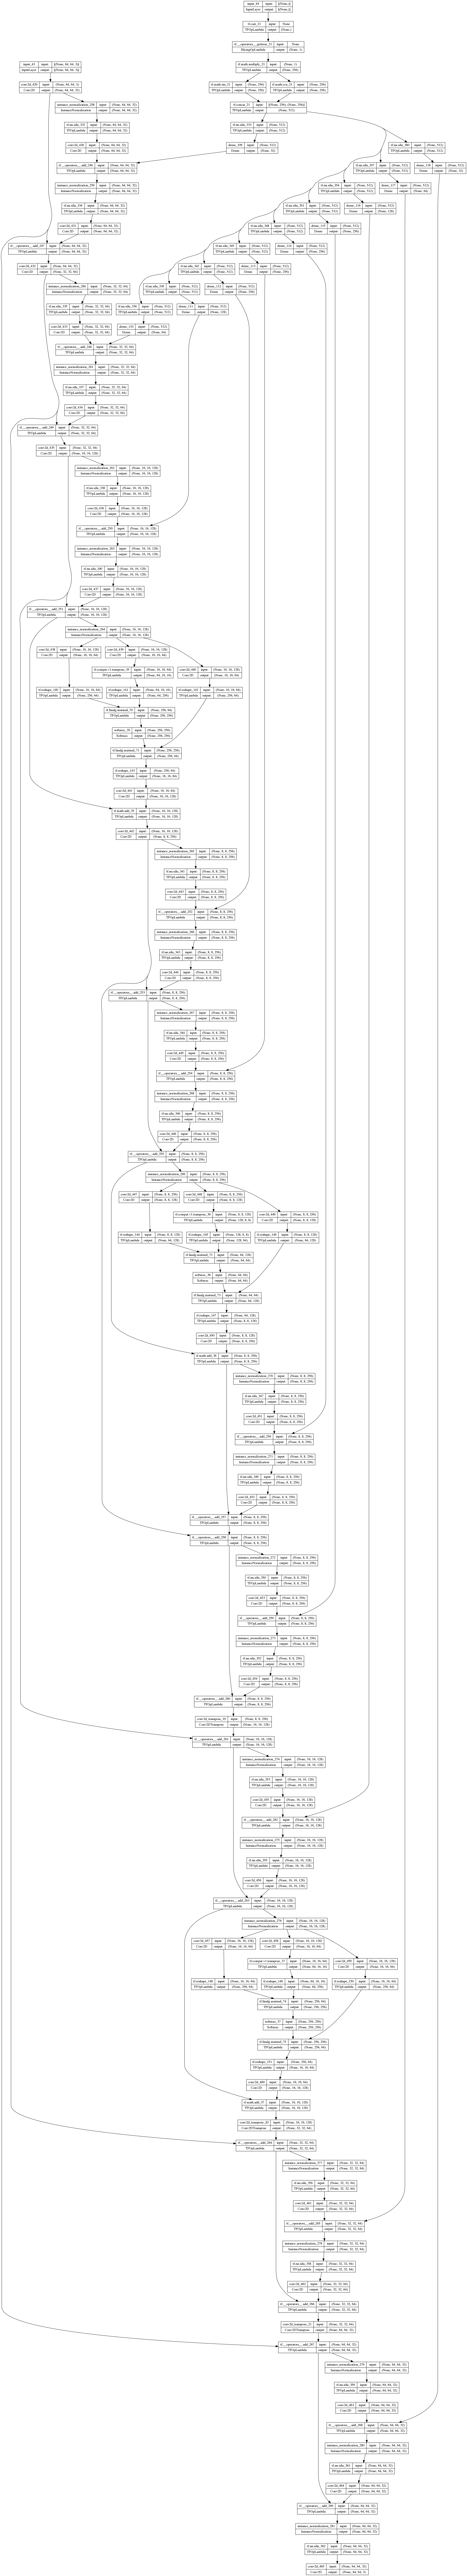

In [46]:
tf.keras.utils.plot_model(u_net1.build_graph(), show_shapes=True)